In [ ]:
import os
import cv2
import shutil
from google.colab import drive

# 1. Mount drive
drive.mount('/content/drive')

# 2. Path setup
RAW_PATH = '/content/drive/MyDrive/RESEARCH_PAPER/Raw_Videos'
DATASET_PATH = '/content/drive/MyDrive/RESEARCH_PAPER/dataset'

# Clear old data if it exists
if os.path.exists(DATASET_PATH):
    shutil.rmtree(DATASET_PATH)

def extract_balanced_frames(input_subfolder, output_subfolder, frames_per_video=80):
    input_dir = os.path.join(RAW_PATH, input_subfolder)
    output_dir = os.path.join(DATASET_PATH, output_subfolder)
    os.makedirs(output_dir, exist_ok=True)

    videos = [f for f in os.listdir(input_dir) if f.lower().endswith(('.mp4', '.mov', '.avi'))]
    print(f"Processing: {input_subfolder} ({len(videos)} videos)")

    for v_name in videos:
        cap = cv2.VideoCapture(os.path.join(input_dir, v_name))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0: continue

        interval = max(1, total_frames // frames_per_video)
        count, saved = 0, 0
        while saved < frames_per_video:
            ret, frame = cap.read()
            if not ret: break
            if count % interval == 0:
                cv2.imwrite(os.path.join(output_dir, f"{v_name}_f{saved}.jpg"), frame)
                saved += 1
            count += 1
        cap.release()

extract_balanced_frames('Real', 'real', frames_per_video=80)
extract_balanced_frames('AI', 'ai', frames_per_video=80)
print("✅ Step 1 finished!")

Mounted at /content/drive
প্রসেসিং: Real (66 টি ভিডিও)
প্রসেসিং: AI (89 টি ভিডিও)
✅ ধাপ ১ শেষ!


In [ ]:
import numpy as np

train_dir = '/content/dataset_final/train'
val_dir = '/content/dataset_final/val'

for cl in ['real', 'ai']:
    os.makedirs(os.path.join(train_dir, cl), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cl), exist_ok=True)

    all_frames = os.listdir(os.path.join(DATASET_PATH, cl))
    video_names = list(set([f.split('_f')[0] for f in all_frames]))

    np.random.shuffle(video_names)
    split = int(0.8 * len(video_names))

    for f in all_frames:
        v_name = f.split('_f')[0]
        src = os.path.join(DATASET_PATH, cl, f)
        if v_name in video_names[:split]:
            shutil.copy(src, os.path.join(train_dir, cl, f))
        else:
            shutil.copy(src, os.path.join(val_dir, cl, f))

print("✅ Step 2 finished!")

✅ ধাপ ২ শেষ!


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, regularizers

# Data generator
datagen = ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='binary')
val_gen = datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=32, class_mode='binary')

def build_model(base_layer):
    base_layer.trainable = False
    model = models.Sequential([
        base_layer,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.6),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 1. ResNet50
print("🚀 Training ResNet50...")
res_model = build_model(tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_res = res_model.fit(train_gen, epochs=10, validation_data=val_gen)

# 2. Xception
print("🚀 Training Xception...")
xcp_model = build_model(tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_xcp = xcp_model.fit(train_gen, epochs=10, validation_data=val_gen)

# 3. MobileNetV2
print("🚀 Training MobileNetV2...")
mob_model = build_model(tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3)))
history_mob = mob_model.fit(train_gen, epochs=10, validation_data=val_gen)

Found 10308 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
🚀 Training ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 124s 339ms/step - accuracy: 0.5607 - loss: 3.8271 - val_accuracy: 0.7405 - val_loss: 1.3143
Epoch 2/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 89s 276ms/step - accuracy: 0.6482 - loss: 1.1260 - val_accuracy: 0.7380 - val_loss: 0.7520
Epoch 3/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 83s 258ms/step - accuracy: 0.6707 - loss: 0.7574 - val_accuracy: 0.7735 - val_loss: 0.6756
Epoch 4/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 85s 262ms/step - accuracy: 0.6811 - loss: 0.6939 - val_accuracy: 0.7465 - val_loss: 0.6461
Epoch 5/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 89s 277ms/step - accuracy: 0.6835 - loss: 0.6742 - val_accuracy: 0.7490 - val_loss: 0.6298
Epoch 6/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 83s 257ms/step - accuracy: 0.6836 - loss: 0.6513 - val_accuracy: 0.7705 - val_loss: 0.6146
Epoch 7/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 83s 257ms/step - accuracy: 0.6861 - loss: 0.6440 - val_accuracy: 0.7735 - val_loss: 0.6042
Epoch 8/10
323/323 ━━━━━━━━━━━━━━━━━━━━ 83s 257ms/step - accuracy: 0.6899 - loss: 


🏆 RESEARCH COMPARISON TABLE
     Algorithm  Accuracy
0     ResNet50    0.7765
1     Xception    0.7480
2  MobileNetV2    0.7295


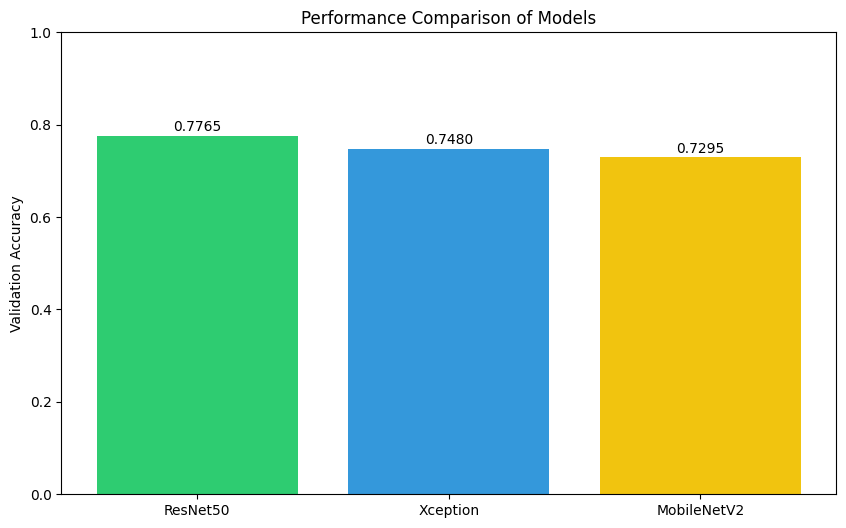

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

results = {
    'Algorithm': ['ResNet50', 'Xception', 'MobileNetV2'],
    'Accuracy': [max(history_res.history['val_accuracy']),
                 max(history_xcp.history['val_accuracy']),
                 max(history_mob.history['val_accuracy'])]
}

df = pd.DataFrame(results)
print("\n🏆 RESEARCH COMPARISON TABLE")
print(df)

# graph
plt.figure(figsize=(10,6))
plt.bar(df['Algorithm'], df['Accuracy'], color=['#2ecc71', '#3498db', '#f1c40f'])
plt.ylim(0, 1.0)
plt.title('Performance Comparison of Models')
plt.ylabel('Validation Accuracy')
for i, v in enumerate(df['Accuracy']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()

In [ ]:

res_model.layers[0].trainable = True

res_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("🚀 ResNet50 fine tuning...")
final_history = res_model.fit(train_gen, epochs=5, validation_data=val_gen)

# model save
res_model.save('/content/drive/MyDrive/RESEARCH_PAPER/final_best_dance_model.keras')
print("✅ model saved!")

🚀 ResNet50 ফাইন-টিউনিং শুরু হচ্ছে...
Epoch 1/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 214s 469ms/step - accuracy: 0.8262 - loss: 0.4535 - val_accuracy: 0.3955 - val_loss: 1.6575
Epoch 2/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 119s 368ms/step - accuracy: 0.9975 - loss: 0.0765 - val_accuracy: 0.6920 - val_loss: 1.1833
Epoch 3/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 118s 366ms/step - accuracy: 0.9992 - loss: 0.0596 - val_accuracy: 0.7475 - val_loss: 1.3118
Epoch 4/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 119s 367ms/step - accuracy: 0.9994 - loss: 0.0543 - val_accuracy: 0.7445 - val_loss: 1.3587
Epoch 5/5
323/323 ━━━━━━━━━━━━━━━━━━━━ 118s 365ms/step - accuracy: 0.9995 - loss: 0.0493 - val_accuracy: 0.7430 - val_loss: 1.3099
✅ আপনার গবেষণার সেরা মডেলটি সেভ করা হয়েছে!


63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 274ms/step


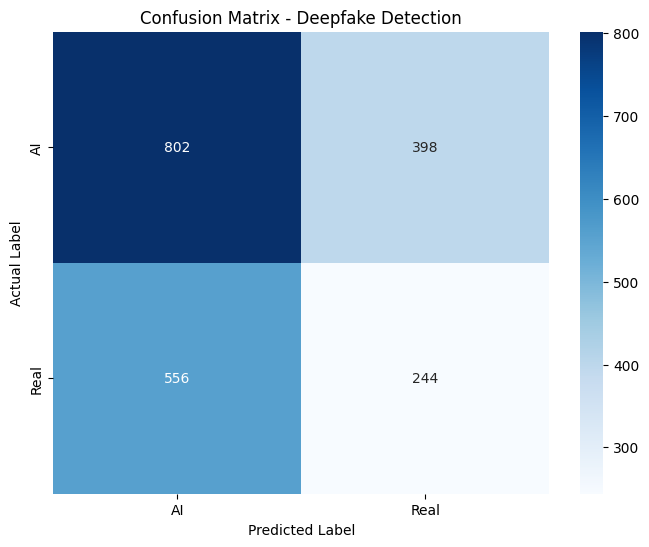


📝 Classification Report:
              precision    recall  f1-score   support

          AI       0.59      0.67      0.63      1200
        Real       0.38      0.30      0.34       800

    accuracy                           0.52      2000
   macro avg       0.49      0.49      0.48      2000
weighted avg       0.51      0.52      0.51      2000



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Take predictions from validation data
val_gen.reset()
Y_pred = res_model.predict(val_gen)
y_pred = (Y_pred > 0.5).astype(int).flatten()
y_true = val_gen.classes

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ['AI', 'Real']  # According to the data generator class index

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Deepfake Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print detailed report
print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from sklearn.utils import class_weight
import numpy as np

# Class weight calculation (so the model gives more importance to Real videos)

class_weights = {0: 1.0, 1: 1.5}

# Reload model architecture (ResNet50)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model_final = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.7),  # Increased dropout to reduce overfitting
    layers.Dense(1, activation='sigmoid')
])

# Reducing learning rate and add callbacks
optimizer = optimizers.Adam(learning_rate=0.0001)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_final.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training
print("🚀 Final training started to stabilize accuracy...")
history = model_final.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weights,  # Using class weights
    callbacks=[early_stop]
)

# Save the model
model_final.save('/content/drive/MyDrive/RESEARCH_PAPER/stable_best_model.keras')

🚀 একুরেসি স্থিতিশীল করার জন্য ফাইনাল ট্রেনিং শুরু হচ্ছে...
Epoch 1/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 103s 282ms/step - accuracy: 0.6879 - loss: 6.6581 - val_accuracy: 0.7775 - val_loss: 2.7613
Epoch 2/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 85s 262ms/step - accuracy: 0.8044 - loss: 2.3123 - val_accuracy: 0.7585 - val_loss: 1.5937
Epoch 3/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 79s 245ms/step - accuracy: 0.8375 - loss: 1.4294 - val_accuracy: 0.7615 - val_loss: 1.2451
Epoch 4/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 252ms/step - accuracy: 0.8654 - loss: 1.0775 - val_accuracy: 0.7345 - val_loss: 1.0831
Epoch 5/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 81s 249ms/step - accuracy: 0.8746 - loss: 0.8929 - val_accuracy: 0.7595 - val_loss: 0.9511
Epoch 6/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 82s 253ms/step - accuracy: 0.8838 - loss: 0.7572 - val_accuracy: 0.7375 - val_loss: 0.8754
Epoch 7/15
323/323 ━━━━━━━━━━━━━━━━━━━━ 80s 248ms/step - accuracy: 0.8968 - loss: 0.6599 - val_accuracy: 0.7285 - val_loss: 0.8452
Epoch 8/15
323/323 ━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


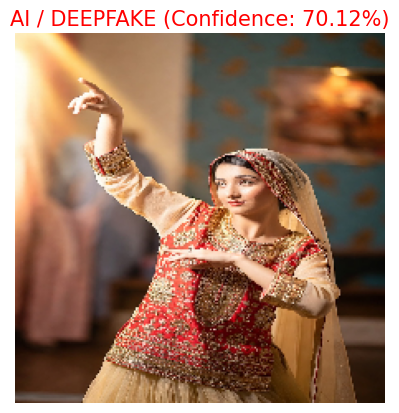

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def predict_deepfake(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalization

    # prediction (from our saved model)
    prediction = model_final.predict(img_array)

    # showing the result
    plt.imshow(img)
    plt.axis('off')

    if prediction[0] > 0.5:
        result = f"REAL (Confidence: {prediction[0][0]*100:.2f}%)"
        color = 'green'
    else:
        result = f"AI / DEEPFAKE (Confidence: {(1-prediction[0][0])*100:.2f}%)"
        color = 'red'

    plt.title(result, color=color, fontsize=15)
    plt.show()

test_image_path = '/content/drive/MyDrive/RESEARCH_PAPER/test.mp4'
predict_deepfake(test_image_path)

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, regularizers

# Advanced data augmentation (to compensate for the shortage of Real images)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Rotate up to 20 degrees
    width_shift_range=0.2,  # Shift left and right
    height_shift_range=0.2, # Shift up and down
    shear_range=0.2,        # Apply shear transformation
    zoom_range=0.2,         # Apply zoom
    horizontal_flip=True,   # Flip like a mirror
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation needed for validation

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # Important to keep shuffle off for report generation
)

# Model architecture (ResNet50)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model_plus = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Learning rate and weight balancing
# Increased importance of Real videos by setting to 2.0
class_weights = {0: 1.0, 1: 2.0}

model_plus.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training
print("Training with augmentation to improve F1-score...")
history = model_plus.fit(
    train_gen,
    epochs=12,
    validation_data=val_gen,
    class_weight=class_weights
)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

val_gen.reset()
preds = model_plus.predict(val_gen)
y_pred = (preds > 0.5).astype(int).flatten()
y_true = val_gen.classes

print("\n New Classification Report:")
print(classification_report(y_true, y_pred, target_names=['AI', 'Real']))